<a href="https://colab.research.google.com/github/hungngo97/Fourier-transform-localization/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
TODO: 
Step 1: Build dataset
  - Probably 10 companies should be enough but try to gather from different fields
  - Each company gather its 3 year(?) stock end of date history + related info 
  such as Description, Financial data such as high/low/Pricebook
  ==> Each company is a row but stock data is a dataframe?
  - Collect another data table for S&P 500 to keep track of local economy 
  to predict company's performance (https://datahub.io/core/s-and-p-500#readme)
  ==> Try to match similar time from S&P500 for company stock data above
  
  TODO:
  perform spectrogram -> clustering on that new spectrogram to detect pattern
  perform 1D cnn
  
  TODO:
  use a LSTM and transformer network to perform prediction
  Introduce more local nearest neighbor later to improve prediction
  
  TODO:
  Use sparse regression to interpret dependency between companies
  
  Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
  
  Simple Exponential Smoothing (SES)
  
  Add more dimensions to input output LSTM
  
  Convolution NN for time series prediction
  
"""

In [0]:
!pip install quandl

# Section 1: Reading Local Data from Google Drive

In [0]:
# Code to read csv file into Colaboratory:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
filenames = ['appl.csv', 'dow.csv', 'ge.csv', 'googl.csv', 
            'msft.csv', 'ndaq.csv', 'qcom.csv', 'sbux.csv',
            'sp500.csv', 'companyInfo.csv']
links = ['https://drive.google.com/open?id=16nTgI_dCcp_sE9D_9p4rGpnduor7TinZ',
         'https://drive.google.com/open?id=1uGoY6WdxCikPQUQMkWT200MiL_osZl8p',
        'https://drive.google.com/open?id=1gObLhrQAKjTuRRyUoQNM0i8WUyzPWaER',
        'https://drive.google.com/open?id=1d0xSZw0IBzsyKWe0QUO8ELkZNsuJZTaz',
        'https://drive.google.com/open?id=1YfIzYhvPi93lmWiu3kRp4_3ZXHrIlpKj',
        'https://drive.google.com/open?id=1898MYq3yIl4HifdCLmjHbvxI-rZAMJyx',
        'https://drive.google.com/open?id=1Uc1i8-1-y_rrUnRWf_NMknm6hI5XUROr',
        'https://drive.google.com/open?id=1saxPuHUE_FxUzvLfAmCag6__Xdp0APw4',
        'https://drive.google.com/open?id=1USDDk1ydtnOya_5mpBEus9u0AymEYr_6',
        'https://drive.google.com/open?id=1YFTMkfRxxv9sQdKFXjzXScjfSaA2Q4Cr']
for index, filename in enumerate(filenames):
  _, id = links[index].split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

appl = pd.read_csv('appl.csv')
dow = pd.read_csv('dow.csv')
ge = pd.read_csv('ge.csv')
googl = pd.read_csv('googl.csv')
msft = pd.read_csv('msft.csv')
ndaq = pd.read_csv('ndaq.csv')
qcom = pd.read_csv('qcom.csv')
sbux = pd.read_csv('sbux.csv')
sp500 = pd.read_csv('sp500.csv')
companyInfo = pd.read_csv('companyInfo.csv')

In [0]:
appl.columns

In [0]:
fig, axs = plt.subplots(3,3, figsize=(15, 15))
axs[0][0].plot(appl['close'])
axs[0][1].plot(dow['close'])
axs[0][2].plot(ge['close'])
axs[1][0].plot(googl['close'])
axs[1][1].plot(msft['close'])
axs[1][2].plot(ndaq['close'])
axs[2][0].plot(qcom['close'])
axs[2][1].plot(sbux['close'])
axs[2][2].plot(sp500['Real Price'])

print(appl.shape)
print(dow.shape)
print(ge.shape)
print(googl.shape)
print(msft.shape)
print(ndaq.shape)
print(qcom.shape)
print(sbux.shape)
print(sp500.shape)


# Preprocess the data to be the same size

In [0]:
data = {}
sentiment_data = {}
for timestep in dow['time']:
#   print("[INFO] Current time: " , str(timestep))
  values = {}
  values_sentiment = {}
  shouldAdd = True
  for company, name in [(appl, 'appl'), (dow, 'dow'), (ge, 'ge'), 
                  (googl, 'googl'), (msft, 'msft'), (ndaq, 'ndaq'),
                  (qcom, 'qcom'), (sbux, 'sbux')]:
    price = company.loc[(company['time'] >= timestep - 10000) 
                        & (company['time'] <= timestep + 100000)]
    if price.empty:
      shouldAdd = False
      break
    values[name] = price['close'].iloc[0] 
    values_sentiment[name] = price['MA100'].iloc[0]
  if shouldAdd:
#     print("[INFO] values at current time:" , values)
    data['t' + str(timestep)] = values
    sentiment_data['t' + str(timestep)] = values_sentiment
  
  

In [0]:
price_df = pd.DataFrame.from_dict(data).T
sentiment_df = pd.DataFrame.from_dict(sentiment_data).T
df.shape
sentiment_df.shape

# Perform Time Series Clustering Based On Price

In [0]:
from scipy import stats
import scipy.cluster.hierarchy as hac


price_df = price_df.dropna()
sentiment_df = sentiment_df.dropna()
df = price_df
Z = hac.linkage(df.T, method='single', metric='correlation')


In [0]:
# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [0]:
from sklearn.decomposition import PCA
num_pc = 2

X = np.asarray(df)
[n,m] = X.shape
print("Timestamps: ", str(n))
print("Stocks: " , str(m))

pca = PCA(n_components=num_pc) # number of principal components
pca.fit(X)

percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print('the variance is explained by the first 2 PCs: ', str(percentage_cum[-1]*100))

pca_components = pca.components_

In [0]:
x = np.arange(1,len(percentage)+1,1)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.bar(x, percentage*100, align = "center")
plt.title('Contribution of principal components',fontsize = 16)
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([0, num_pc+1])

plt.subplot(1, 2, 2)
plt.plot(x, percentage_cum*100,'ro-')
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.title('Cumulative contribution of principal components',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)
plt.xlim([1, num_pc])
plt.ylim([50,100]);

In [0]:
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(columns=["factor 1", "factor 2"], 
                              index=df.index,
                              data=factor_returns)
factor_returns.head()

In [0]:
factor_exposures = pd.DataFrame(index=["factor 1", "factor 2"], 
                                columns=df.columns,
                                data = pca.components_).T

In [0]:
factor_exposures

In [0]:
labels = factor_exposures.index
data = factor_exposures.values

In [0]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker='o', s=300, c='m',
    cmap=plt.get_cmap('Spectral'))
plt.title('Scatter Plot of Coefficients of PC1 and PC2')
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    );

In [0]:
# TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X.T)

In [0]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(tsne_results[:, 1])))
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=colors )
fig.legend(fontsize='small')
for label, x, y in zip(labels, tsne_results[:, 0], tsne_results[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    );

In [0]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

# Spectrogram Clustering

In [0]:
from scipy import signal
fs = 2**15
f, t, Sxx = signal.spectrogram(X[:,0], fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Data Preprocessing

In [0]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def split_train_test(series, n_test):
	# split into train and test sets
	train, test = series.iloc[0:-n_test], series[-n_test:]
	return train, test

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test
 

In [0]:
data = series_to_supervised(df)

In [0]:
data_appl = concat([data['var1(t-1)'], data['var1(t)']], axis = 1)
data_dow = concat([data['var2(t-1)'], data['var2(t)']], axis = 1)
data_ge = concat([data['var3(t-1)'], data['var3(t)']], axis = 1)
data_googl = concat([data['var4(t-1)'], data['var4(t)']], axis = 1)
data_msft = concat([data['var5(t-1)'], data['var5(t)']], axis = 1)
data_ndaq = concat([data['var6(t-1)'], data['var6(t)']], axis = 1)
data_qcom = concat([data['var7(t-1)'], data['var7(t)']], axis = 1)
data_sbux = concat([data['var8(t-1)'], data['var8(t)']], axis = 1)


In [0]:
train_appl, test_appl = split_train_test(data_appl, 10)
train_dow, test_dow = split_train_test(data_dow, 10)
train_ge, test_ge = split_train_test(data_ge, 10)
train_googl, test_googl = split_train_test(data_googl, 10)
train_msft, test_msft = split_train_test(data_msft, 10)
train_ndaq, test_ndaq = split_train_test(data_ndaq, 10)
train_qcom, test_qcom = split_train_test(data_qcom, 10)
train_sbux, test_sbux = split_train_test(data_sbux, 10)


In [0]:
def plot_train_test(train, test):
  plt.plot(range(train.shape[0]), train.iloc[:,0],
          range(train.shape[0], train.shape[0] + test.shape[0]),test.iloc[:,0] )

In [0]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train_appl, test_appl = prepare_data(df['appl'], n_test, n_lag, n_seq)
train_dow, test_dow = prepare_data(df['dow'], n_test, n_lag, n_seq)
train_ge, test_ge = prepare_data(df['ge'], n_test, n_lag, n_seq)
train_googl, test_googl = prepare_data(df['googl'], n_test, n_lag, n_seq)
train_qcom, test_qcom = prepare_data(df['qcom'], n_test, n_lag, n_seq)
train_ndaq, test_ndaq = prepare_data(df['ndaq'], n_test, n_lag, n_seq)
train_sbux, test_sbux = prepare_data(df['sbux'], n_test, n_lag, n_seq)
train_msft, test_msft = prepare_data(df['msft'], n_test, n_lag, n_seq)

# Trial 1: Plain LSTM Neural Net

In [0]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
series = df['appl']
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

t+1 RMSE: 1.518766
t+2 RMSE: 1.732322
t+3 RMSE: 2.084867


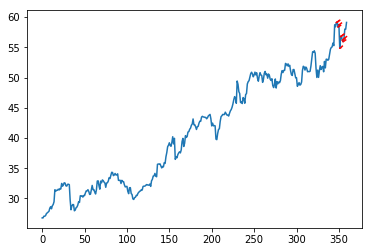

In [176]:
series = df['ndaq']
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

t+1 RMSE: 18.484968
t+2 RMSE: 18.247634
t+3 RMSE: 25.052202


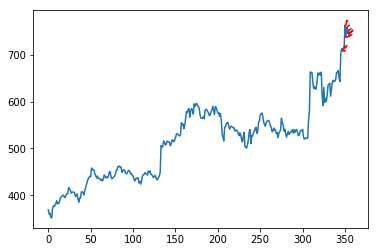

In [177]:
series = df['googl']
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

In [0]:
# # plot the entire dataset in blue
# pyplot.plot(series.values)
# plot the forecasts in red
for i in range(len(forecasts)):
  off_s = len(series) - n_test + i - 1
  off_e = off_s + len(forecasts[i]) + 1
  if (off_e > len(series)): 
    break
  xaxis = [x for x in range(off_s, off_e)]
  yaxis = [series.values[off_s]] + forecasts[i]
  pyplot.plot(xaxis, yaxis, color='red')
  pyplot.plot(xaxis, series.values[xaxis])
# show the plot
pyplot.show()

# Sparse Regression to Retrieve Company Coefficients and Relationships

# LSTM Neural Net Prediction